In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# Create weight
CELL_W_SIZE = 64
ncells = CELL_W_SIZE * CELL_W_SIZE

dirs = np.array([[0.0, np.pi/2.0],
                         [np.pi, 3*np.pi/2.0]])
dirs = np.tile(dirs, (CELL_W_SIZE//2, CELL_W_SIZE//2))
dirs = np.reshape(dirs.T, (-1))

dir_vects = np.vstack([np.cos(dirs), np.sin(dirs)])

x = np.arange(0, CELL_W_SIZE) - (CELL_W_SIZE-1) / 2.0

X,Y = np.meshgrid(x,x)

x = np.vstack([np.reshape(X.T, (-1)), np.reshape(Y.T, (-1))])
# (2, 4096)

# Sets length of field shift in recurrent connections
cell_spacing = Y[1,0] - Y[0,0]

# Offset of center of inhibitory output
ell = 2 * cell_spacing

# Distance from (0,0) for A below
cell_dists = np.linalg.norm(x.T, 2, axis=1)
# (4096,)

# if >1, uses local excitatory connections
a = 1

# Approx the periodicity of the pattern
lambda_ = 13                   

# Width of the excitatory region
beta = 3 / (lambda_ * lambda_) 

# How much inhibitory region wider than excitatory
gamma = 1.1 * beta              

W = []

for i in range(ncells):
    tmp = np.tile(np.reshape(x[:,i], (2,1)), (1, ncells))
    # (2,4096)
    shifts = tmp - x - ell * dir_vects
    # (2,4096)

    squared_shift_lengths = np.linalg.norm(shifts.T, 2, axis=1) ** 2
    # (4096,)
    
    tmp = a * np.exp(-gamma * squared_shift_lengths) - np.exp(-beta * squared_shift_lengths)
    # (4096,)
    W.append(tmp)


W = np.vstack(W)

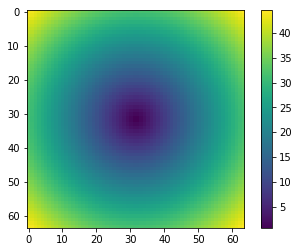

In [34]:
# Visualize cell_dists
fig, ax = plt.subplots()
cell_dists_map = ax.imshow(np.reshape(cell_dists,  [CELL_W_SIZE, CELL_W_SIZE]))
fig.colorbar(cell_dists_map)
plt.show()

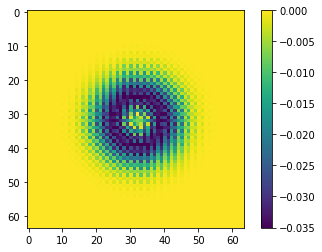

In [30]:
# Visualize weight at the center
center_w = W[CELL_W_SIZE * (CELL_W_SIZE//2) + (CELL_W_SIZE//2)]
# (4096,)

center_w = np.reshape(center_w, [CELL_W_SIZE, CELL_W_SIZE])

fig, ax = plt.subplots()
weight_map = ax.imshow(center_w)
fig.colorbar(weight_map)
plt.show()

In [39]:
# Simulate
R   = np.sqrt(ncells)/2     # radius of main network, in cell-position units
a0 = np.sqrt(ncells)/32  # envelope fall-off rate
dr  = np.sqrt(ncells)/2    # radius of tapered region, in cell-position units

A = (((cell_dists) - R + dr) / dr)
A = np.exp(-a0 * A * A)

#non_tapered_inds = find(cellDists < (R-dr));
#A(nonTaperedInds) = 1

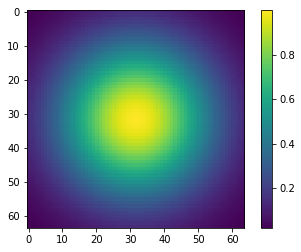

In [40]:
# Visualize A
fig, ax = plt.subplots()
A_map = ax.imshow(np.reshape(A,  [CELL_W_SIZE, CELL_W_SIZE]))
fig.colorbar(A_map)
plt.show()

In [36]:
dt = 0.5 # time step, ms
tau = 10.0

s = np.random.uniform(low=0.0, high=1.0, size=[ncells])
# (4096,)

for i in range(1000):
    # Feedforward input
    #B = A .* (1 + alpha * dirVects' * v)'
    B = A
    # (4096,)
    
    # Total synaptic driving currents
    s_inputs = np.dot(W, s.T).T + B
    
    # Synaptic drive only increases if input cells are over threshold 0
    s_inputs = np.maximum(s_inputs, 0.0)
    
    # Synaptic drive decreases with time constant tau
    s = s + dt * (s_inputs - s) / tau

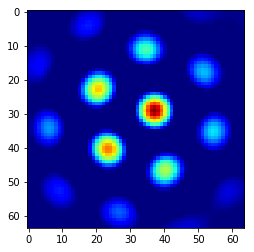

In [37]:
plt.imshow(np.reshape(s, [CELL_W_SIZE, CELL_W_SIZE]),  cmap="jet")